# 导模块

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from MyEvalCriteria import mae,rmse,corr,KGE,ia,BHV

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import  mean_absolute_error 

import pickle

from imp import reload
import MyPrepaData
reload(MyPrepaData)

<module 'MyPrepaData' from 'D:\\python_programming\\jupyter\\再分析的预测2\\MyPrepaData.py'>

In [18]:
# 计算阈值
data = pd.read_csv('2011-2018再分析和流量数据.csv',index_col=0)
d1 = list(data.Q.sort_values(ascending=False).values)
a = len(d1)
# plt.vlines(ymin=0,ymax=6000,x=a*0.2)
# plt.plot(d1)
print(d1[int(a*0.2)])

1722


In [19]:
# 准备数据
data = pd.read_csv('2011-2018再分析和流量数据.csv',index_col=0)
micQ1 = pd.read_excel('result.xls',index_col=1,header=None)
reanalysis = micQ1.index[:8]

In [20]:
reanalysis

Index(['stl3', 'd2m', 'tcwv', 'tcw', 'stl2', 'mn2t', 'tsn', 'stl4'], dtype='object', name=1)

In [21]:
def calcAllEC(y_true,y_fore):
    return ['%.4f' % mae(y_true, y_fore),
            '%.4f' % rmse(y_true, y_fore),
            '%.4f' % corr(y_true, y_fore),
            '%.4f' % KGE(y_true, y_fore),
            '%.4f' % BHV(y_true, y_fore),
            '%.4f' % ia(y_true, y_fore),]

In [22]:
def readdata(leadtime):
    para = pd.read_csv('leadtime%d_lbfgs_self.csv' % leadtime, index_col=0, header=[0, 1, 2])

    idx = pd.IndexSlice
    logistic_test_mae = para.loc[:, idx[:, ['logistic'], 'test_mae']]
    tanh_test_mae = para.loc[:, idx[:, ['tanh'], 'test_mae']]
    identity_test_mae = para.loc[:, idx[:, ['identity'], 'test_mae']]
    relu_test_mae = para.loc[:, idx[:, ['relu'], 'test_mae']]
    logistic_test_mae.columns = range(2, 21, 1)
    tanh_test_mae.columns = range(2, 21, 1)
    identity_test_mae.columns = range(2, 21, 1)
    relu_test_mae.columns = range(2, 21, 1)
    df = None
    for i in logistic_test_mae:
        df_temp = pd.DataFrame(logistic_test_mae[i].iloc[:-2].values, columns=['MAE'])
        df_temp['Activation function'] = ['logistic' for k in range(df_temp.shape[0])]
        df_temp['Number of nodes'] = [i for k in range(df_temp.shape[0])]

        df_temp1 = pd.DataFrame(tanh_test_mae[i].iloc[:-2].values, columns=['MAE'])
        df_temp1['Activation function'] = ['tanh' for k in range(df_temp1.shape[0])]
        df_temp1['Number of nodes'] = [i for k in range(df_temp1.shape[0])]

        df_temp2 = pd.DataFrame(identity_test_mae[i].iloc[:-2].values, columns=['MAE'])

        df_temp2['Activation function'] = ['identity' for k in range(df_temp2.shape[0])]
        df_temp2['Number of nodes'] = [i for k in range(df_temp2.shape[0])]

        df_temp3 = pd.DataFrame(relu_test_mae[i].iloc[:-2].values, columns=['MAE'])
        df_temp3['Activation function'] = ['relu' for k in range(df_temp3.shape[0])]
        df_temp3['Number of nodes'] = [i for k in range(df_temp3.shape[0])]
        if df is None:
            df = pd.concat([df_temp, df_temp1, df_temp2, df_temp3], axis=0)
        else:
            df = pd.concat([df, df_temp, df_temp1, df_temp2, df_temp3], axis=0)
    df['MAE'] = df['MAE'].astype('float')
    return df

In [23]:
ANNpara = []
for leadtime in range(1,11):
    idx = pd.IndexSlice
    para = pd.read_csv('leadtime%d_lbfgs_self.csv' % leadtime, index_col=0, header=[0, 1, 2])
    temp = para.loc[:,idx[:,:,'test_mae']].median().idxmin()
    ANNpara.append((temp[0],temp[1]))
ANNpara

[('4', 'tanh'),
 ('2', 'tanh'),
 ('3', 'logistic'),
 ('2', 'logistic'),
 ('2', 'logistic'),
 ('2', 'logistic'),
 ('2', 'logistic'),
 ('2', 'logistic'),
 ('2', 'tanh'),
 ('2', 'tanh')]

# 神经网络

In [14]:
# 使用所有的特征
idx = pd.IndexSlice
names = locals()
itera = 50
result = pd.DataFrame(columns=pd.MultiIndex.from_product([range(1,11),['obs','pred'],['train','val','test']]),index=range(1451))
for leadtime in range(1,11,1):
    X, y =  MyPrepaData.Preparation(data=data,Qlag=[1,4],Rlag=range(1,7),reanalysis=reanalysis,isreanalysis=True,leadtime=leadtime)
    scalemodely = MinMaxScaler().fit(np.array(y).reshape(-1, 1)) 
    scalemodelx = MinMaxScaler().fit(X)
    y_scale = scalemodely.transform(np.array(y).reshape(-1, 1))
    X_scale = scalemodelx.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scale,y_scale,test_size=730,shuffle=False)
    X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train,y_train,test_size=731,shuffle=False)
    model = MLPRegressor(hidden_layer_sizes=(int(ANNpara[leadtime-1][0]),), activation=ANNpara[leadtime-1][1], solver='lbfgs',
                         alpha=0.0001,batch_size='auto',learning_rate='constant',learning_rate_init=0.001, power_t=0.5,
                         max_iter=3000, shuffle=True,random_state=None,tol=1e-5, verbose=False, warm_start=False,momentum=0.9, 
                         nesterovs_momentum=True,early_stopping=True, validation_fraction=0.1,beta_1=0.9,beta_2=0.999, 
                         epsilon=1e-08,n_iter_no_change=10)
    names['trainset%d'%leadtime] = pd.DataFrame()
    names['valset%d'%leadtime] = pd.DataFrame()
    names['testset%d'%leadtime] = pd.DataFrame()
    for i in range(itera):
        model.fit(X_train,y_train.ravel())

        y_fit = model.predict(X_train_val)
        y_fit_val = model.predict(X_test_val)
        y_pred = model.predict(X_test)

        y_train_val_,y_test_val_,y_test_,y_fit_,y_fit_val_,y_pred_ = scalemodely.inverse_transform(y_train_val.reshape(-1, 1)),\
        scalemodely.inverse_transform(y_test_val.reshape(-1, 1)),scalemodely.inverse_transform(y_test.reshape(-1, 1)),\
        scalemodely.inverse_transform(y_fit.reshape(-1, 1)),scalemodely.inverse_transform(y_fit_val.reshape(-1, 1)),\
         scalemodely.inverse_transform(y_pred.reshape(-1, 1))
        names['trainset%d'%leadtime][i] = y_fit_.ravel()
        names['valset%d'%leadtime][i] = y_fit_val_.ravel()
        names['testset%d'%leadtime][i] = y_pred_.ravel()
    result.loc[:,idx[[leadtime],['pred'],['train']]] = names['trainset%d'%leadtime].median(axis=1)
    result.loc[:,idx[[leadtime],['pred'],['val']]] = names['valset%d'%leadtime].median(axis=1)
    result.loc[:,idx[[leadtime],['pred'],['test']]] = names['testset%d'%leadtime].median(axis=1)
    result.loc[:,idx[[leadtime],['obs'],['train']]] = pd.Series(y_train_val_.ravel())
    result.loc[:,idx[[leadtime],['obs'],['val']]] =  pd.Series(y_test_val_.ravel())
    result.loc[:,idx[[leadtime],['obs'],['test']]] =  pd.Series(y_test_.ravel())
result.to_csv('ANNresult.csv')

# 支持向量机

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [18]:
for leadtime in range(1,11,1):
    with open('svr_para%d.pickle'%(leadtime), 'rb') as f:
        svr_cv = pickle.load(f)
    print(svr_cv.best_params_)

{'C': 6.2105263157894735, 'epsilon': 0.0068736842105263166, 'gamma': 0.03226315789473684}
{'C': 1.0, 'epsilon': 0.008436842105263158, 'gamma': 0.05831578947368421}
{'C': 1.0, 'epsilon': 0.0016631578947368423, 'gamma': 0.08436842105263158}
{'C': 1.0, 'epsilon': 0.00791578947368421, 'gamma': 0.02705263157894737}
{'C': 11.421052631578947, 'epsilon': 0.0016631578947368423, 'gamma': 0.006210526315789474}
{'C': 1.0, 'epsilon': 0.0001, 'gamma': 0.021842105263157895}
{'C': 1.0, 'epsilon': 0.0021842105263157894, 'gamma': 0.03747368421052632}
{'C': 6.2105263157894735, 'epsilon': 0.0006210526315789474, 'gamma': 0.01663157894736842}
{'C': 1.0, 'epsilon': 0.004789473684210527, 'gamma': 0.06873684210526315}
{'C': 6.2105263157894735, 'epsilon': 0.004268421052631579, 'gamma': 0.01663157894736842}


In [19]:
import warnings
warnings.filterwarnings('ignore')
idx = pd.IndexSlice
result = pd.DataFrame(columns=pd.MultiIndex.from_product([range(1,11),['obs','pred'],['train','val','test']]),index=range(1451))
for leadtime in range(1,11,1):
    with open('svr_para%d.pickle'%(leadtime), 'rb') as f:
        svr_cv = pickle.load(f)
    X, y =  MyPrepaData.Preparation(data=data,Qlag=[1,4],Rlag=range(1,7),reanalysis=reanalysis,isreanalysis=True,leadtime=leadtime)
    scalemodely = MinMaxScaler().fit(np.array(y).reshape(-1, 1)) 
    scalemodelx = MinMaxScaler().fit(X)
    y_scale = scalemodely.transform(np.array(y).reshape(-1, 1))
    X_scale = scalemodelx.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scale,y_scale,test_size=730,shuffle=False)
    X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train,y_train,test_size=731,shuffle=False)
    
    model = SVR(**svr_cv.best_params_)   
    model.fit(X_train,y_train.ravel())
    y_fit = model.predict(X_train_val)
    y_fit_val = model.predict(X_test_val)
    y_pred = model.predict(X_test)

    y_train_val_,y_test_val_,y_test_,y_fit_,y_fit_val_,y_pred_ = scalemodely.inverse_transform(y_train_val.reshape(-1, 1)),\
    scalemodely.inverse_transform(y_test_val.reshape(-1, 1)),scalemodely.inverse_transform(y_test.reshape(-1, 1)),\
    scalemodely.inverse_transform(y_fit.reshape(-1, 1)),scalemodely.inverse_transform(y_fit_val.reshape(-1, 1)),\
     scalemodely.inverse_transform(y_pred.reshape(-1, 1))
    result.loc[:,idx[[leadtime],['pred'],['train']]] = pd.Series(y_fit_.ravel())
    result.loc[:,idx[[leadtime],['pred'],['val']]] = pd.Series(y_fit_val_.ravel())
    result.loc[:,idx[[leadtime],['pred'],['test']]] = pd.Series(y_pred_.ravel())
    result.loc[:,idx[[leadtime],['obs'],['train']]] = pd.Series(y_train_val_.ravel())
    result.loc[:,idx[[leadtime],['obs'],['val']]] =  pd.Series(y_test_val_.ravel())
    result.loc[:,idx[[leadtime],['obs'],['test']]] =  pd.Series(y_test_.ravel())
    print(leadtime,'/','10')
result.to_csv('SVRresult.csv')

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


# 梯度提升回归

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

import pickle
import copy

In [30]:
%%time
names = locals()
result = pd.DataFrame(columns=pd.MultiIndex.from_product([range(1,11),['obs','pred'],['train','val','test']]),index=range(1461))
with open('gbrt_allpara_learn_est.pickle', 'rb') as f:
    optpara = pickle.load(f)
n_estimators= [_['n_estimators'] for _ in optpara]
learning_rate = [_['learning_rate'] for _ in optpara]
with open('gbrt_allpara.pickle', 'rb') as f:
    optpara = pickle.load(f)
min_samples_split= [_['min_samples_split'] for _ in optpara]
min_samples_leaf = [_['min_samples_leaf'] for _ in optpara]
max_depth = [_['max_depth'] for _ in optpara]
max_leaf_nodes = [_['max_leaf_nodes'] for _ in optpara]
gbrtresult = {}
itera = 50
for leadtime in range(1,11,1): 
    X,y = MyPrepaData.Preparation(data=data,Qlag=[1,4],Rlag=range(1,7),reanalysis=reanalysis,isreanalysis=True,leadtime=leadtime)
    scalemodely = MinMaxScaler().fit(np.array(y).reshape(-1, 1)) 
    scalemodelx = MinMaxScaler().fit(X)
    y_scale = scalemodely.transform(np.array(y).reshape(-1, 1))
    X_scale = scalemodelx.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scale,y_scale,test_size=730,shuffle=False)
    X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train,y_train,test_size=731,shuffle=False)
    model = GradientBoostingRegressor(n_estimators = n_estimators[leadtime-1],min_samples_split= min_samples_split[leadtime-1],
                                          max_depth = max_depth[leadtime-1],max_leaf_nodes=max_leaf_nodes[leadtime-1],
                                          min_samples_leaf=min_samples_leaf[leadtime-1],learning_rate=learning_rate[leadtime-1])
    names['trainset%d'%leadtime] = pd.DataFrame()
    names['valset%d'%leadtime] = pd.DataFrame()
    names['testset%d'%leadtime] = pd.DataFrame()
#     feature importance
    if leadtime == 1:
        feature_importance1 = []
    elif leadtime==10:
        feature_importance10 = []
    for i in range(itera):
        model.fit(X_train,y_train.ravel())

        y_fit = model.predict(X_train_val)
        y_fit_val = model.predict(X_test_val)
        y_pred = model.predict(X_test)

        y_train_val_,y_test_val_,y_test_,y_fit_,y_fit_val_,y_pred_ = scalemodely.inverse_transform(y_train_val.reshape(-1, 1)),\
        scalemodely.inverse_transform(y_test_val.reshape(-1, 1)),scalemodely.inverse_transform(y_test.reshape(-1, 1)),\
        scalemodely.inverse_transform(y_fit.reshape(-1, 1)),scalemodely.inverse_transform(y_fit_val.reshape(-1, 1)),\
         scalemodely.inverse_transform(y_pred.reshape(-1, 1))
        names['trainset%d'%leadtime][i] = y_fit_.ravel()
        names['valset%d'%leadtime][i] = y_fit_val_.ravel()
        names['testset%d'%leadtime][i] = y_pred_.ravel()
        
        if leadtime==1:
            feature_importance1.append(model.feature_importances_)
        elif leadtime==10:
            feature_importance10.append(model.feature_importances_)
    if leadtime==1:
        fi1 = pd.DataFrame(feature_importance1)
        fi1.columns = X.columns
        fi1 = fi1.mean().sort_values()
    elif leadtime==10:
        fi10 = pd.DataFrame(feature_importance10)
        fi10.columns = X.columns
        fi10 = fi10.mean().sort_values()
    result.loc[:,idx[[leadtime],['pred'],['train']]] = names['trainset%d'%leadtime].median(axis=1)
    result.loc[:,idx[[leadtime],['pred'],['val']]] = names['valset%d'%leadtime].median(axis=1)
    result.loc[:,idx[[leadtime],['pred'],['test']]] = names['testset%d'%leadtime].median(axis=1)
    result.loc[:,idx[[leadtime],['obs'],['train']]] = pd.Series(y_train_val_.ravel())
    result.loc[:,idx[[leadtime],['obs'],['val']]] =  pd.Series(y_test_val_.ravel())
    result.loc[:,idx[[leadtime],['obs'],['test']]] =  pd.Series(y_test_.ravel())
    print(leadtime,'/','10')
fi1.to_csv('featureimportance1.csv')
fi10.to_csv('featureimportance10.csv')
result.to_csv('GBRTresult.csv')

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Wall time: 23min 42s


In [33]:
%%time
result = pd.DataFrame(columns=pd.MultiIndex.from_product([range(1,11),['obs','pred'],['train','val','test']]),index=range(1451))
with open('gbrt_allpara_learn_est_nore.pickle', 'rb') as f:
    optpara = pickle.load(f)
n_estimators= [_['n_estimators'] for _ in optpara]
learning_rate = [_['learning_rate'] for _ in optpara]
with open('gbrt_allpara_nore.pickle', 'rb') as f:
    optpara = pickle.load(f)
min_samples_split= [_['min_samples_split'] for _ in optpara]
min_samples_leaf = [_['min_samples_leaf'] for _ in optpara]
max_depth = [_['max_depth'] for _ in optpara]
max_leaf_nodes = [_['max_leaf_nodes'] for _ in optpara]
gbrtresult = {}
itera = 50
for leadtime in range(1,11,1):
    X,y = MyPrepaData.Preparation(data=data,Qlag=[1,4],Rlag=range(1,7),reanalysis=reanalysis,isreanalysis=False,leadtime=leadtime)
    scalemodely = MinMaxScaler().fit(np.array(y).reshape(-1, 1)) 
    scalemodelx = MinMaxScaler().fit(X)
    y_scale = scalemodely.transform(np.array(y).reshape(-1, 1))
    X_scale = scalemodelx.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scale,y_scale,test_size=730,shuffle=False)
    X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train,y_train,test_size=731,shuffle=False)
    model = GradientBoostingRegressor(n_estimators = n_estimators[leadtime-1],min_samples_split= min_samples_split[leadtime-1],
                                          max_depth = max_depth[leadtime-1],max_leaf_nodes=max_leaf_nodes[leadtime-1],
                                          min_samples_leaf=min_samples_leaf[leadtime-1],learning_rate=learning_rate[leadtime-1])
    names['trainset%d'%leadtime] = pd.DataFrame()
    names['valset%d'%leadtime] = pd.DataFrame()
    names['testset%d'%leadtime] = pd.DataFrame()
    for i in range(itera):
        model.fit(X_train,y_train.ravel())

        y_fit = model.predict(X_train_val)
        y_fit_val = model.predict(X_test_val)
        y_pred = model.predict(X_test)

        y_train_val_,y_test_val_,y_test_,y_fit_,y_fit_val_,y_pred_ = scalemodely.inverse_transform(y_train_val.reshape(-1, 1)),\
        scalemodely.inverse_transform(y_test_val.reshape(-1, 1)),scalemodely.inverse_transform(y_test.reshape(-1, 1)),\
        scalemodely.inverse_transform(y_fit.reshape(-1, 1)),scalemodely.inverse_transform(y_fit_val.reshape(-1, 1)),\
         scalemodely.inverse_transform(y_pred.reshape(-1, 1))
        names['trainset%d'%leadtime][i] = y_fit_.ravel()
        names['valset%d'%leadtime][i] = y_fit_val_.ravel()
        names['testset%d'%leadtime][i] = y_pred_.ravel()
    result.loc[:,idx[[leadtime],['pred'],['train']]] = names['trainset%d'%leadtime].median(axis=1)
    result.loc[:,idx[[leadtime],['pred'],['val']]] = names['valset%d'%leadtime].median(axis=1)
    result.loc[:,idx[[leadtime],['pred'],['test']]] = names['testset%d'%leadtime].median(axis=1)
    result.loc[:,idx[[leadtime],['obs'],['train']]] = pd.Series(y_train_val_.ravel())
    result.loc[:,idx[[leadtime],['obs'],['val']]] =  pd.Series(y_test_val_.ravel())
    result.loc[:,idx[[leadtime],['obs'],['test']]] =  pd.Series(y_test_.ravel())
    print(leadtime,'/','10')
result.to_csv('GBRTREresult.csv')

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Wall time: 3min 25s


# 多元回归

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
result = pd.DataFrame(columns=pd.MultiIndex.from_product([range(1,11),['obs','pred'],['train','val','test']]),index=range(1451))

for leadtime in range(1,11,1):
    X,y = MyPrepaData.Preparation(data=data,Qlag=[1,4],Rlag=range(1,7),reanalysis=reanalysis,isreanalysis=True,leadtime=leadtime)
    scalemodely = MinMaxScaler().fit(np.array(y).reshape(-1, 1)) 
    scalemodelx = MinMaxScaler().fit(X)
    y_scale = scalemodely.transform(np.array(y).reshape(-1, 1))
    X_scale = scalemodelx.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scale,y_scale,test_size=730,shuffle=False)
    X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train,y_train,test_size=731,shuffle=False)
    
    model = LinearRegression()
    model.fit(X_train,y_train.ravel())
    y_fit = model.predict(X_train_val)
    y_fit_val = model.predict(X_test_val)
    y_pred = model.predict(X_test)

    y_train_val_,y_test_val_,y_test_,y_fit_,y_fit_val_,y_pred_ = scalemodely.inverse_transform(y_train_val.reshape(-1, 1)),\
    scalemodely.inverse_transform(y_test_val.reshape(-1, 1)),scalemodely.inverse_transform(y_test.reshape(-1, 1)),\
    scalemodely.inverse_transform(y_fit.reshape(-1, 1)),scalemodely.inverse_transform(y_fit_val.reshape(-1, 1)),\
     scalemodely.inverse_transform(y_pred.reshape(-1, 1))
    result.loc[:,idx[[leadtime],['obs'],['train']]] = pd.Series(y_train_val_.ravel())
    result.loc[:,idx[[leadtime],['obs'],['val']]] = pd.Series(y_test_val_.ravel())
    result.loc[:,idx[[leadtime],['obs'],['test']]] = pd.Series(y_test_.ravel())
    result.loc[:,idx[[leadtime],['pred'],['train']]] = pd.Series(y_fit_.ravel())
    result.loc[:,idx[[leadtime],['pred'],['val']]] =  pd.Series(y_fit_val_.ravel())
    result.loc[:,idx[[leadtime],['pred'],['test']]] =  pd.Series(y_pred_.ravel())
    print(leadtime,'/','10')
result.to_csv('MLRresult.csv')

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


# 计算指标

In [7]:
idx = pd.IndexSlice
estimate_criteria = pd.DataFrame(columns=pd.MultiIndex.from_product([['GBRT','ANN','SVR','MLR','GBRTRE'],
                                                                     ['train','val','test'],
                                                                     ['MAE', 'RMSE','CORR','KGE','BHV','ia']]))
for model in ['GBRT','ANN','SVR','MLR','GBRTRE']:
    result = pd.read_csv('%sresult.csv'%model,index_col=0,header=[0, 1, 2])
    for leadtime in range(1,11):
        y_train_val_ = result.loc[:,idx[[str(leadtime)],['obs'],['train']]].dropna().values
        y_test_val_ = result.loc[:,idx[[str(leadtime)],['obs'],['val']]].dropna().values
        y_test_ = result.loc[:,idx[[str(leadtime)],['obs'],['test']]].dropna().values
        
        y_fit_ = result.loc[:,idx[[str(leadtime)],['pred'],['train']]].dropna().values
        y_fit_val_ = result.loc[:,idx[[str(leadtime)],['pred'],['val']]].dropna().values
        y_pred_ = result.loc[:,idx[[str(leadtime)],['pred'],['test']]].dropna().values
        
        estimate_criteria.loc[leadtime,idx[model,'train',:]],estimate_criteria.loc[leadtime,idx[model,'val',:]],\
        estimate_criteria.loc[leadtime,idx[model,'test',:]] = [calcAllEC(y_fit_, y_train_val_),calcAllEC(y_fit_val_, y_test_val_),\
        calcAllEC(y_pred_, y_test_)]

In [8]:
estimate_criteria.astype('float').to_csv('finalresult.csv')

In [9]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'
order = ['GBRT','SVR','ANN', 'MLR']
df  = estimate_criteria.loc[:,idx[:,'test','ia',:]].droplevel(axis=1,level=(1,2))
df = df[order].T.astype('float')
df = df.applymap(lambda x:'%.4f'%x)
df.index = ['GBRT-MIC','SVR-MIC','ANN-MIC', 'MLR-MIC']
df

,1,2,3,4,5,6,7,8,9,10
GBRT-MIC,0.9856,0.9753,0.9710,0.9686,0.9661,0.9601,0.9571,0.9535,0.9485,0.9419
SVR-MIC,0.9869,0.9763,0.9676,0.9568,0.9495,0.9421,0.9396,0.9372,0.9351,0.9326
ANN-MIC,0.9872,0.9779,0.9701,0.9637,0.9590,0.9532,0.9486,0.9442,0.9405,0.9408
MLR-MIC,0.9865,0.9759,0.9661,0.9577,0.9511,0.9441,0.9392,0.9360,0.9320,0.9295


# 绘图，绘制预测结果的时序图和散点图

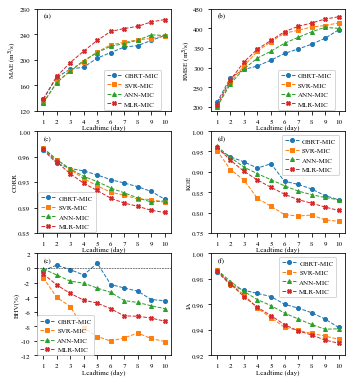

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.ticker as ticker
import numpy as np
rcParams.update({'font.size': 7})
rcParams['font.sans-serif'] = 'Times New Roman'
ftd = {'family':'Times New Roman','size':7}
paralegend = {'title':None,'frameon':None,'handlelength':2,'handletextpad':0.5}
# paralegend = {}
# data = pd.read_csv(open(r'data\result.csv'),index_col=[0],header=[0,1,2])
data = estimate_criteria
idx = pd.IndexSlice
data = data.drop(['GBRTRE'],axis='columns',level=0) #删除GBRT
data.index.name='leadtime'
data.columns.name = ['model','set','ec']
# print(data.loc[:,idx[['GBRTMIC','SVR','ANN','MLR'], ['test'], :]])
# print(data.sort_index(axis=1,level=2))
# exit(1)
plt.figure(figsize=(5.51,6.375))
for indice,ix,num in zip(['MAE', 'RMSE','CORR','KGE','BHV','ia'],range(1,7),['(a)','(b)','(c)','(d)','(e)','(f)']):
    ax = plt.subplot('32%d'%(ix))
    k = 0
    names = locals()
    names[indice] = data.loc[:, idx[:, ['test'], [indice]]]
#     print(names[indice])
#     break
    
    names[indice] = names[indice].astype('float32')
    names[indice].columns=['GBRTMIC','ANN','SVR','MLR']
    names[indice] = names[indice][['GBRTMIC','SVR','ANN','MLR']]
    for i,marker in zip(names[indice].columns,['o', 's', '^', 'X']):
        plt.plot(names[indice][i], marker=marker, linestyle='dashed', linewidth=1, markersize=4)

    plt.xticks(range(1,11))

    if indice == 'RMSE':
        plt.ylim(190,450)
        plt.yticks(np.linspace(200,450,6))
        plt.ylabel('%s (m$^3$/s)'%indice,labelpad=0.1)
        plt.text(x=0.05,y=0.92,s=num, transform=ax.transAxes,fontdict=ftd)
        loc = (0.5, 0.01)
    elif indice=='MAE':
        plt.ylim(120,280)
        plt.yticks(np.linspace(120,280,5))
        plt.ylabel('%s (m$^3$/s)'%indice,labelpad=0.1)
        plt.text(x=0.05,y=0.92,s=num, transform=ax.transAxes,fontdict=ftd)
        loc = (0.5, 0.01)
    elif indice=='KGE':
        plt.ylim(0.75,1.0)
        plt.yticks(np.linspace(0.75,1.0,6))
        formatter = ticker.FormatStrFormatter('%1.2f')
        ax.yaxis.set_major_formatter(formatter)
        plt.ylabel(indice,labelpad=0.1)
        plt.text(x=0.05, y=0.92, s=num, transform=ax.transAxes, fontdict=ftd)
        loc = (0.53, 0.57)
    elif indice=='CORR':
        formatter = ticker.FormatStrFormatter('%1.2f')
        ax.yaxis.set_major_formatter(formatter)
        plt.ylim(0.85,1.0)
        plt.yticks(np.linspace(0.85,1.0,5))
        plt.ylabel(indice,labelpad=0.1)
        plt.text(x=0.05, y=0.92, s=num, transform=ax.transAxes, fontdict=ftd)
        loc = (0.01, 0.01)
    elif indice=='BHV':
        formatter = ticker.FormatStrFormatter('%d')
        ax.yaxis.set_major_formatter(formatter)
        plt.ylim(-12,2)
        plt.yticks(np.linspace(-12,2,8))
        plt.axhline(y=0,lw=0.5,ls='--',c='k')
        plt.ylabel('%s(%s)'%(indice,'%'),labelpad=0.1)
        plt.text(x=0.05, y=0.92, s=num, transform=ax.transAxes, fontdict=ftd)
        loc = (0.0, 0.0)
    elif indice=='ia':
        formatter = ticker.FormatStrFormatter('%1.2f')
        ax.yaxis.set_major_formatter(formatter)
        plt.ylim(0.92,1.0)
        # plt.yticks(np.linspace(0.85,1.0,5))
        plt.ylabel(indice,labelpad=0.1)
        plt.text(x=0.05, y=0.92, s=num, transform=ax.transAxes, fontdict=ftd)
        loc = (0.51, 0.57)
        plt.ylabel('IA')

    # if indice in ['KGE','CORR']:
    #     loc = (0.5,0.55)
    plt.legend(['GBRT-MIC','SVR-MIC','ANN-MIC','MLR-MIC'],loc=loc,**paralegend)
    plt.xlabel('Leadtime (day)',labelpad=0.1)
plt.subplots_adjust(wspace =0.3)#调整子图间距
plt.savefig('fig\Model_comparision.tif',dpi=500,bbox_inches = 'tight')
plt.show()

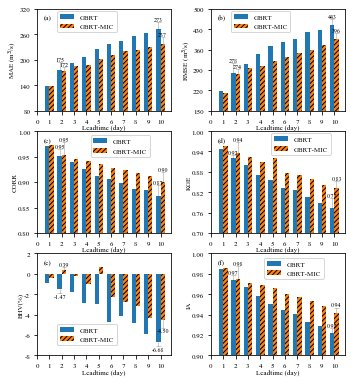

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker
from matplotlib.pyplot import MultipleLocator
import numpy as np
rcParams['font.sans-serif'] = 'Times New Roman'
rcParams.update({'font.size': 7})
#paralegend = {'title':None,'frameon':None,'handlelength':3,'handletextpad':1.5,'borderpad':0.8}
paralegend = {}
data = estimate_criteria
idx = pd.IndexSlice
data = data.drop(['SVR','ANN','MLR'],axis='columns',level=0) #'SVR','ANN','MLR'

ftd = {'family':'Times New Roman','size':7}
plt.figure(figsize=(5.51,6.375))
for indice,ix,num in zip(['MAE', 'RMSE','CORR','KGE','BHV','ia'],range(1,7),['(a)','(b)','(c)','(d)','(e)','(f)']):
    ax = plt.subplot('32%d' % (ix))
    names = locals()
    names[indice] = data.loc[:, idx[['GBRT', 'GBRTRE'],['test'],[indice]]]
    names[indice] = names[indice].astype('float32')
    width = 0.35
    para = {'alpha': 1.0, 'width': width}

    # 添加差异变化量
    gbrt = names[indice].values[:, 1]
    gbrtmic = names[indice].values[:, 0]
    plt.bar(x=np.arange(1, 11) - width / 2, height=gbrt, label='GBRT', **para)
    plt.bar(x=np.arange(1, 11) + width / 2, height=gbrtmic, label='GBRT-MIC', hatch='/////',**para)
    linealpha = 0.4
    if indice=='CORR':
        for para_paint in [(2,0.013,0.025),(10,0.02,0.02)]:
            leadtime,a,b = para_paint
            plt.vlines(x=leadtime - width / 2, ymin=gbrt[leadtime - 1], ymax=gbrt[leadtime - 1] + a, lw=0.5,alpha=linealpha)
            plt.hlines(y=gbrt[leadtime - 1] + a, xmin=leadtime - width, xmax=leadtime, lw=0.5,alpha=linealpha)
            plt.text(x=leadtime - width / 2, y=gbrt[leadtime - 1] + a, s='%.2f' % (gbrt[leadtime - 1]), ha='center',
                     va='bottom', fontdict={'fontsize':6})
            plt.text(x=leadtime + width / 2, y=gbrtmic[leadtime - 1] + b, s='%.2f' % (gbrtmic[leadtime - 1]), ha='center',
                     va='bottom', fontdict={'fontsize':6})
            plt.vlines(x=leadtime + width / 2, ymin=gbrtmic[leadtime - 1], ymax=gbrtmic[leadtime - 1] + b, lw=0.5,alpha=linealpha)
            plt.hlines(y=gbrtmic[leadtime - 1] + b, xmin=leadtime + width, xmax=leadtime, lw=0.5,alpha=linealpha)
        plt.ylabel(indice,labelpad=0.1)
        plt.ylim(0.8, 1.0)  # CORR
        y_major_locator = MultipleLocator(0.05)
        ax.yaxis.set_major_locator(y_major_locator)
        formatter = ticker.FormatStrFormatter('%1.2f')
        ax.yaxis.set_major_formatter(formatter)
        plt.legend(loc=(0.4, 0.75), **paralegend)
        plt.text(x=0.05, y=0.9, s=num, transform=ax.transAxes, fontdict=ftd)
        # ax2 = ax.twinx()
        # ax2.plot(range(1,11),gbrtmic-gbrt,  'o-')
        # ax2.plot(range(1, 11), (gbrtmic - gbrt)/gbrtmic, 'o-')
    elif indice=='KGE':
        for para_paint in [(2,0.01,0.03),(10,0.03,0.02)]:
            leadtime,a,b = para_paint
            plt.vlines(x=leadtime - width / 2, ymin=gbrt[leadtime - 1], ymax=gbrt[leadtime - 1] + a, lw=0.5,alpha=linealpha)
            plt.hlines(y=gbrt[leadtime - 1] + a, xmin=leadtime - width, xmax=leadtime, lw=0.5,alpha=linealpha)
            plt.text(x=leadtime - width / 2, y=gbrt[leadtime - 1] + a, s='%.2f' % (gbrt[leadtime - 1]), ha='center',
                     va='bottom', fontdict={'fontsize':6})
            plt.text(x=leadtime + width / 2, y=gbrtmic[leadtime - 1] + b, s='%.2f' % (gbrtmic[leadtime - 1]), ha='center',
                     va='bottom', fontdict={'fontsize':6})
            plt.vlines(x=leadtime + width / 2, ymin=gbrtmic[leadtime - 1], ymax=gbrtmic[leadtime - 1] + b, lw=0.5,alpha=linealpha)
            plt.hlines(y=gbrtmic[leadtime - 1] + b, xmin=leadtime + width, xmax=leadtime, lw=0.5,alpha=linealpha)
        plt.ylabel(indice,labelpad=0.1)
        formatter = ticker.FormatStrFormatter('%1.2f')
        ax.yaxis.set_major_formatter(formatter)
        plt.ylim(0.7,1.0)  # NSE
        yticks = np.linspace(0.7,1.0,6)
        plt.yticks(yticks)
        # y_major_locator = MultipleLocator(0.05)
        # ax.yaxis.set_major_locator(y_major_locator)
        plt.legend(loc=(0.45, 0.77),**paralegend)
        plt.text(x=0.05, y=0.9, s=num, transform=ax.transAxes, fontdict=ftd)

        # ax2 = ax.twinx()
        # ax2.plot(range(1,11),gbrtmic-gbrt,  'o-')
        # ax2.plot(range(1, 11), (gbrtmic - gbrt)/gbrtmic, 'o-')
    elif indice=='MAE':
        for para_paint in [(2,10,20),(10,15,15)]:
            leadtime,a,b = para_paint
            plt.vlines(x=leadtime - width / 2, ymin=gbrt[leadtime - 1], ymax=gbrt[leadtime - 1] + b, lw=0.5,alpha=linealpha)
            plt.hlines(y=gbrt[leadtime - 1] + b, xmin=leadtime - width, xmax=leadtime, lw=0.5,alpha=linealpha)
            plt.text(x=leadtime - width / 2, y=gbrt[leadtime - 1] + b, s='%.d' % (gbrt[leadtime - 1]), ha='center',
                     va='bottom', fontdict={'fontsize':6})
            plt.text(x=leadtime + width / 2, y=gbrtmic[leadtime - 1] + a, s='%.d' % (gbrtmic[leadtime - 1]), ha='center',
                     va='bottom', fontdict={'fontsize':6})
            plt.vlines(x=leadtime + width / 2, ymin=gbrtmic[leadtime - 1], ymax=gbrtmic[leadtime - 1] + a, lw=0.5,alpha=linealpha)
            plt.hlines(y=gbrtmic[leadtime - 1] + a, xmin=leadtime + width, xmax=leadtime, lw=0.5,alpha=linealpha)

        plt.ylabel('%s (m$^3$/s)' % indice,labelpad=0.1)
        plt.ylim(80,320)  # CORR
        yticks = np.linspace(80,320,5)
        plt.yticks(yticks)
        # y_major_locator = MultipleLocator(40)
        # ax.yaxis.set_major_locator(y_major_locator)
        # 把y轴的主刻度设置为40的倍数
        plt.legend(loc=(0.15, 0.77),**paralegend)
        plt.text(x=0.05, y=0.9, s=num, transform=ax.transAxes, fontdict=ftd)
        # ax2 = ax.twinx()
        # ax2.plot(range(1,11),gbrt-gbrtmic,  'o-')
        # ax2.plot(range(1,11), (gbrt - gbrtmic)/gbrtmic, 'o-')
    elif indice == 'RMSE':
        for para_paint in [(2,35,20),(10,20,20)]:
            leadtime,a,b = para_paint
            plt.vlines(x=leadtime - width / 2, ymin=gbrt[leadtime - 1], ymax=gbrt[leadtime - 1] + a, lw=0.5,alpha=linealpha)
            plt.hlines(y=gbrt[leadtime - 1] + a, xmin=leadtime - width, xmax=leadtime, lw=0.5,alpha=linealpha)
            plt.text(x=leadtime - width / 2, y=gbrt[leadtime - 1] + a, s='%.d' % (gbrt[leadtime - 1]), ha='center',
                     va='bottom', fontdict={'fontsize':6})
            plt.text(x=leadtime + width / 2, y=gbrtmic[leadtime - 1] + b, s='%.d' % (gbrtmic[leadtime - 1]), ha='center',
                     va='bottom', fontdict={'fontsize':6})
            plt.vlines(x=leadtime + width / 2, ymin=gbrtmic[leadtime - 1], ymax=gbrtmic[leadtime - 1] + b, lw=0.5,alpha=linealpha)
            plt.hlines(y=gbrtmic[leadtime - 1] + b, xmin=leadtime + width, xmax=leadtime, lw=0.5,alpha=linealpha)

        error = (names[indice].values[:, 1] - names[indice].values[:, 0]) / names[indice].values[:, 0]
        # plt.text(x=2, y=names[indice].values[:, 1][1] + 10, s='%.2f%%' % (error[1] * 100), ha='center', va='bottom')
        # plt.text(x=10, y=names[indice].values[:, 1][-1] + 10, s='%.2f%%' % (error[-1] * 100), ha='center', va='bottom')
        plt.ylabel('%s (m$^3$/s)' % indice,labelpad=0.1)
        plt.ylim(150,500)  # RMSE
        yticks = np.linspace(150,500,6)
        plt.yticks(yticks)
        plt.legend(loc=(0.15,0.77),**paralegend)
        plt.text(x=0.05, y=0.9, s=num, transform=ax.transAxes, fontdict=ftd)
        # ax2 = ax.twinx()
        # ax2.plot(range(1,11),gbrt-gbrtmic,  'o-')
        # ax2.plot(range(1, 11), (gbrt - gbrtmic)/gbrtmic, 'o-')
    elif indice == 'BHV':
        for para_paint in [(2, -0.4, 0.3), (10, -0.45, -0.85)]:
            leadtime, a, b = para_paint
            plt.vlines(x=leadtime - width / 2, ymin=gbrt[leadtime - 1], ymax=gbrt[leadtime - 1] + a, lw=0.5,
                       alpha=linealpha)
            plt.hlines(y=gbrt[leadtime - 1] + a, xmin=leadtime - width, xmax=leadtime, lw=0.5, alpha=linealpha)

            if leadtime == 10:
                plt.text(x=leadtime - width / 2, y=gbrt[leadtime - 1] + a-0.5, s='%.2f' % (gbrt[leadtime - 1]), ha='center',
                     va='bottom', fontdict={'fontsize': 6})
                plt.text(x=leadtime + width / 2, y=gbrtmic[leadtime - 1] + b-0.5, s='%.2f' % (gbrtmic[leadtime - 1]),
                         ha='center',
                         va='bottom', fontdict={'fontsize': 6})
            else:
                plt.text(x=leadtime - width / 2, y=gbrt[leadtime - 1] + a-0.6, s='%.2f' % (gbrt[leadtime - 1]), ha='center',
                     va='bottom', fontdict={'fontsize': 6})
                plt.text(x=leadtime + width / 2, y=gbrtmic[leadtime - 1] + b, s='%.2f' % (gbrtmic[leadtime - 1]),
                         ha='center',
                         va='bottom', fontdict={'fontsize': 6})
            plt.vlines(x=leadtime + width / 2, ymin=gbrtmic[leadtime - 1], ymax=gbrtmic[leadtime - 1] + b, lw=0.5,
                       alpha=linealpha)
            plt.hlines(y=gbrtmic[leadtime - 1] + b, xmin=leadtime + width, xmax=leadtime, lw=0.5, alpha=linealpha)
        plt.ylabel('%s(%s)'%(indice,'%'), labelpad=0.1)
        formatter = ticker.FormatStrFormatter('%d')
        ax.yaxis.set_major_formatter(formatter)
        plt.ylim(-8, 2.0)  # NSE
        yticks = np.linspace(-8, 2.0, 6)
        plt.yticks(yticks)
        # y_major_locator = MultipleLocator(0.05)
        # ax.yaxis.set_major_locator(y_major_locator)
        plt.legend(loc=(0.15, 0.1), **paralegend)
        plt.text(x=0.05, y=0.9, s=num, transform=ax.transAxes, fontdict=ftd)
    elif indice == 'ia':
        for para_paint in [(2, 0.005, 0.012), (10, 0.005, 0.005)]:
            leadtime, a, b = para_paint
            plt.vlines(x=leadtime - width / 2, ymin=gbrt[leadtime - 1], ymax=gbrt[leadtime - 1] + a, lw=0.5,
                       alpha=linealpha)
            plt.hlines(y=gbrt[leadtime - 1] + a, xmin=leadtime - width, xmax=leadtime, lw=0.5, alpha=linealpha)
            plt.text(x=leadtime - width / 2, y=gbrt[leadtime - 1] + a, s='%.2f' % (gbrt[leadtime - 1]), ha='center',
                     va='bottom', fontdict={'fontsize': 6})
            plt.text(x=leadtime + width / 2, y=gbrtmic[leadtime - 1] + b, s='%.2f' % (gbrtmic[leadtime - 1]),
                     ha='center',
                     va='bottom', fontdict={'fontsize': 6})
            plt.vlines(x=leadtime + width / 2, ymin=gbrtmic[leadtime - 1], ymax=gbrtmic[leadtime - 1] + b, lw=0.5,
                       alpha=linealpha)
            plt.hlines(y=gbrtmic[leadtime - 1] + b, xmin=leadtime + width, xmax=leadtime, lw=0.5, alpha=linealpha)
        plt.ylabel(indice, labelpad=0.1)
        plt.ylim(0.9, 1.0)  # CORR
        y_major_locator = MultipleLocator(0.02)
        ax.yaxis.set_major_locator(y_major_locator)
        formatter = ticker.FormatStrFormatter('%1.2f')
        ax.yaxis.set_major_formatter(formatter)
        plt.legend(loc=(0.4, 0.75), **paralegend)
        plt.text(x=0.05, y=0.9, s=num, transform=ax.transAxes, fontdict=ftd)
        plt.ylabel('IA')
    plt.xlabel(xlabel='Leadtime (day)',labelpad=0.1)
    # plt.xlabel()
    plt.xticks(range(0, 11))
plt.subplots_adjust(wspace =0.3)#调整子图间距
plt.savefig('fig\Input_comparision.tif',dpi=500,bbox_inches = 'tight')
plt.show()

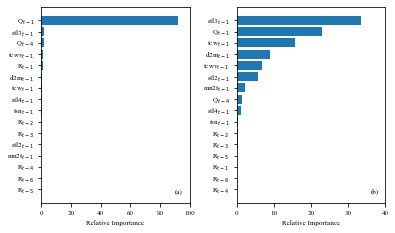

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker
rcParams['font.sans-serif'] = 'Times New Roman'
fig = plt.figure(figsize=(5.51,3.25))
rcParams.update({'font.size': 7})
ax1 = plt.subplot(121)
leadtime=1

data = pd.read_csv('featureimportance%d.csv'%leadtime,header=None)
data[1] = data[1]*100
data.columns = ['pos','feature_importance']
plt.barh(data['pos'], data['feature_importance'], align='center')
xtick = [i[:-5]+'$_{%s}$'%i[-4:-1] for i in data['pos']]
# print(xtick)
plt.yticks(data['pos'], xtick)
plt.xlabel('Relative Importance')
plt.xticks(range(0,101,20))
plt.xlim(0,100)
plt.text(x=0.9, y=0.05, s='(a)', transform=ax1.transAxes)
ax2 = plt.subplot(122)
leadtime=10

data = pd.read_csv('featureimportance%d.csv'%leadtime,header=None)
data[1] = data[1]*100
data.columns = ['pos','feature_importance']
plt.barh(data['pos'], data['feature_importance'], align='center')
xtick = [i[:-6]+'$_{%s}$'%(i[-5:-3]+str(int(i[-3:-1])-9)) for i in data['pos']]
plt.text(x=0.9, y=0.05, s='(b)', transform=ax2.transAxes)
plt.yticks(data['pos'], xtick)
plt.xlabel('Relative Importance')
plt.xticks(range(0,41,10))
plt.xlim(0,40)
fig.tight_layout()#调整整体空白
plt.savefig('fig\Feature_importance.tif',dpi=500)
plt.show()

-3.568946573720978 319.05757070171876


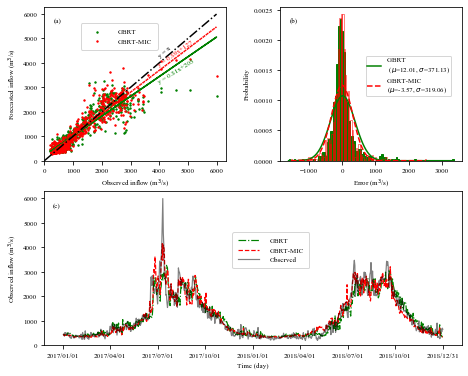

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy.stats import norm
idx = pd.IndexSlice
rcParams.update({'font.size': 7})
paralegend = {'title':None,'frameon':None,'handlelength':3,'handletextpad':1.5,'borderpad':0.8}
# paralegend={}
ftd = {'family':'Times New Roman','size':7}
rcParams['font.sans-serif'] = 'Times New Roman'
leadtime = 5
GBRTresult = pd.read_csv('GBRTresult.csv',index_col=0,header=[0, 1, 2])
GBRTREresult = pd.read_csv('GBRTREresult.csv',index_col=0,header=[0, 1, 2])
GBRTtest = {'real':GBRTresult.loc[:,idx['%d'%leadtime,'obs','test']].dropna(),'pred':GBRTresult.loc[:,idx['%d'%leadtime,'pred','test']].dropna()}
GBRTrealtest = {'real':GBRTresult.loc[:,idx['%d'%leadtime,'obs','test']].dropna(),'pred':GBRTREresult.loc[:,idx['%d'%leadtime,'pred','test']].dropna()}
# MLRtest = pd.read_csv(open(r'data\leadtime%d_MLRtestresult.csv'%leadtime),index_col=0)
# SVRtest = pd.read_csv(open(r'data\leadtime%d_SVRtestresult.csv'%leadtime),index_col=0)
# ANNtest = pd.read_csv(open(r'data\leadtime%d_ANNtestresult.csv'%leadtime),index_col=0)

plt.figure(figsize=(7.48,6.23))
#图（a）
ls = ['solid','dotted','dashdot']
alpha = [1.0,1.0,1.0,1.0]
color = ['green','red','black']
label = ['GBRT','GBRT-MIC']
ax = plt.subplot(221)
def plot_trendline(x, y,ls,color,alpha,label=None,n=1):
    plt.scatter(x, y,s=2,alpha=alpha,c=color,label=label)
    parameter = np.polyfit(x, y, n)
    f = np.poly1d(parameter)
    plt.plot(x, f(x), ls=ls, c=color)
    return parameter
para1 = plot_trendline(GBRTtest['real'],GBRTrealtest['pred'],ls=ls[0],color=color[0],alpha=alpha[0],label=label[0])
para2 = plot_trendline(GBRTrealtest['real'],GBRTtest['pred'],ls=ls[1],color=color[1],alpha=alpha[1],label=label[1])
x = np.linspace(0,GBRTrealtest['real'].max(),100)
plt.plot(x,x,ls=ls[2],color=color[2],alpha=alpha[2],marker=None)
plt.ylim(0,)
plt.xlim(0,)
plt.legend(loc=(0.2,0.72),**paralegend)
plt.text(x=0.62, y=0.67, s='y = x',rotation=41 ,transform=ax.transAxes, fontdict=ftd)
if leadtime ==5:
    plt.text(x=0.62, y=0.61, s='y = %.2fx+%d'%(para2[0],para2[1]),rotation=35 ,transform=ax.transAxes, fontdict=ftd,color='red')
    plt.text(x=0.62, y=0.50, s='y = %.2fx+%d'%(para1[0],para1[1]),rotation=32 ,transform=ax.transAxes, fontdict=ftd,color='green')
elif leadtime==1:
    plt.text(x=0.82, y=0.73, s='y = %.2fx+%d'%(para2[0],para2[1]),rotation=38 ,transform=ax.transAxes, fontdict=ftd,color='red')
    plt.text(x=0.62, y=0.54, s='y = %.2fx+%d'%(para1[0],para1[1]),rotation=38 ,transform=ax.transAxes, fontdict=ftd,color='green')
elif leadtime==10:
    plt.text(x=0.62, y=0.56, s='y = %.2fx+%d'%(para2[0],para2[1]),rotation=32 ,transform=ax.transAxes, fontdict=ftd,color='red')
    plt.text(x=0.62, y=0.44, s='y = %.2fx+%d'%(para1[0],para1[1]),rotation=32 ,transform=ax.transAxes, fontdict=ftd,color='green')
plt.text(x=0.05, y=0.9, s='(a)', transform=ax.transAxes, fontdict=ftd)
plt.ylabel('Forecasted inflow (m$^3$/s)')
plt.xlabel('Observed inflow (m$^3$/s)')

#图（b）
ax = plt.subplot(222)
alpha = 0.6
x = (GBRTrealtest['real']-GBRTrealtest['pred']).values
mu =np.mean(x) #计算均值

sigma =np.std(x)
num_bins = 100 #直方图柱子的数量
n, bins, patches = plt.hist(x, num_bins,density=True, fill=True,facecolor='green',edgecolor='green', alpha=1.0,label=label[0])
#直方图函数，x为x轴的值，normed=1表示为概率密度，即和为一，绿色方块，色深参数0.5.返回n个概率，直方块左边线的x值，及各个方块对象
y = norm.pdf(bins, mu, sigma)#拟合一条最佳正态分布曲线y
plt.plot(bins, y, '-',c='green') #绘制y的曲线

x = (GBRTtest['real']-GBRTtest['pred']).values
mu2 = np.mean(x) #计算均值
sigma2 =np.std(x)
n, bins, patches = plt.hist(x, num_bins,density=True, fill = False,facecolor='white',edgecolor='red', alpha=1.0,label=label[1],lw=0.5)
#直方图函数，x为x轴的值，normed=1表示为概率密度，即和为一，绿色方块，色深参数0.5.返回n个概率，直方块左边线的x值，及各个方块对象
y = norm.pdf(bins, mu2, sigma2)#拟合一条最佳正态分布曲线y
print(mu2,sigma2)
plt.plot(bins, y, '--',c='red') #绘制y的曲线
label = ['GBRT \n ($\mu$=%.2f, $\sigma$=%.2f)'%(mu,sigma),'GBRT-MIC \n($\mu$=%.2f, $\sigma$=%.2f)'%(mu2,sigma2)]
plt.legend(label,loc = (0.47,0.42), borderpad=0.2)
plt.text(x=0.05, y=0.9, s='(b)', transform=ax.transAxes, fontdict=ftd)
plt.ylabel('Probability')
plt.xlabel('Error (m$^3$/s)')
plt.subplots_adjust(wspace =0.3)#调整子图间距
#图（c）
ax = plt.subplot(212)
ls = ['dashdot','dashed','solid']
color = ['green','red','black']
alpha = [1.0,1.0,0.5,0.5]
label = ['GBRT','GBRT-MIC','Observed']
lw=1.2
dates = pd.date_range('20170101','20181231',freq='1D')
plt.plot(dates,GBRTrealtest['pred'].values,ls=ls[0],color=color[0],alpha=alpha[0],label=label[0],lw=lw)
plt.plot(dates,GBRTtest['pred'].values,ls=ls[1],color=color[1],alpha=alpha[1],label=label[1],lw=lw)
plt.plot(dates,GBRTtest['real'].values,ls=ls[2],color=color[2],alpha=alpha[2],label=label[2],lw=lw)
ix = GBRTtest['real'].index
plt.legend(loc = (0.45,0.5),**paralegend)
plt.text(x=0.02, y=0.9, s='(c)', transform=ax.transAxes, fontdict=ftd)
plt.ylim(0,)
plt.ylabel('Observed inflow (m$^3$/s)')
plt.xlabel('Time (day)')
xticks = ['2017/01/01','2017/04/01','2017/07/01','2017/10/01',
          '2018/01/01','2018/04/01','2018/07/01','2018/10/01', '2018/12/31']
plt.xticks(xticks,xticks)
plt.savefig('fig\Input_comparision_result%d.tif'%leadtime,dpi=500,bbox_inches = 'tight')
plt.show()

